In [1]:
%matplotlib inline
%load_ext line_profiler
import sys; sys.path.append('..')
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from os.path import join
from scipy.interpolate import interp1d
from scipy.ndimage import gaussian_filter1d
import seaborn as sns
import colorcet as cc
from ipdb import set_trace
import pandas as pd
from p_tqdm import p_map, p_umap # parallel map
from tqdm.auto import tqdm
from functools import partial
from multiprocessing import RawArray, Pool
pmap = p_map

import PIL
from io import BytesIO
import PIL.Image
from tqdm.auto import tqdm
import umap
from sklearn.manifold import TSNE


from src.simple_utils import load_pickle
from src.data_utils import cifar10_label_names, get_dataset
from cifarclass import cifar100_classes

from pncommon import * # my stuff

#rand_indices = np.random.default_rng(2).choice(np.arange(10000), size=10)
rng = np.random.default_rng(2)

def probs_to_softacc(probs):
    return np.array([probs[i, yi, :] for i, yi in enumerate(ytest)]).mean(0)

## Load Data

In [2]:
name = "CIFAR100_test"
train_set = "CIFAR100_train"

label_mapping=cifar100_classes
classes = list(label_mapping.values())
NUM_SAMPLES = 10000

print("loading data")

all_group_paths = ['../processed/cifar100/clip_new/group2.pkl',
             '../processed/cifar100/resnets/group2.pkl']

all_groups = list(map(load_pickle, tqdm(all_group_paths)))
print("done")

print("loading dataset")
dataset = get_dataset('data', name)
ytest = np.array(dataset.targets)
print("done")


## let's call grouped in 'pn-raw-form'
grouped = {k : g[name][k] for g in all_groups for k in g[name].keys()}
groups = list(grouped.keys())
print('groups: ', groups)

## add soft probs
for _, G in grouped.items():
    G['xsoft'] = probs_to_softacc(G["probs"])

loading data


  0%|          | 0/2 [00:00<?, ?it/s]

done
loading dataset
Files already downloaded and verified
done
groups:  ['ClipViTB32', 'ClipViTB16', 'Resnet18-pretrained', 'Densenet121-pretrained', 'Resnet18', 'Densenet121']


In [3]:
gname = 'ClipViTB32'
G = grouped[gname]

In [4]:
def std_single(Gi, x, gridpts, t="probs", smooth=True, sigma=2.0):
    """
        Return a "standard form" for the stackplots.
        Gi : (NUM_LABELS, NUM_CHECKPOINTS)
        x : the input x-axis (of Gi)
        gridpts : the output x-axis (to standardize wrt)
    """
    xx = gridpts
    res = []
    for j, y in enumerate(Gi):
        # linearly interpolate the curve on uniform grid
        f = interp1d(x, y, kind='linear')
        yy = f(xx)
        if smooth:
            yy = gaussian_filter1d(yy, sigma=sigma) # note that this doesn't mess up the probability simplex
        res.append(yy)
    return np.array(res)

gridpts = 50
t = 'probs'
xkey = 'x' # 'x' or 'xsoft'
x = G[xkey]
xx = np.linspace(x.min(), x.max(), gridpts) # gridpts

i = rng.choice(np.arange(NUM_SAMPLES))
sample = std_single(G[t][i], x, xx, t)

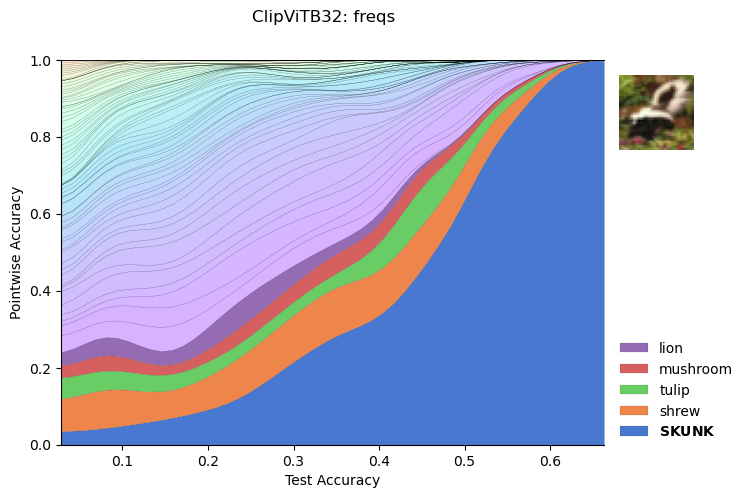

In [5]:
def stacksimple(i, x, prof, topk=5, ax=None):
    """
        i: index of image in dataset
        x: x-axis points
        prof: profile (NUM_LABELS, len(x))
        topk: number of "main" labels, for the legend.
    """
    true_label = ytest[i]
    areas = prof.sum(axis=1)
    areas[true_label] = +np.infty # force true label to be first
    ind = np.argsort(areas)[::-1] # sort labels according to their integrals

    label_names = [classes[idx] if j < topk else '_nolegend_' for j, idx in enumerate(ind)]
    if ax is None:
        f, ax = plt.subplots(figsize=(7, 5))
    
    
    colors = sns.color_palette('muted')[:topk] # first k colors: by palette
    cm = sns.color_palette('rainbow', as_cmap=True)
    fix_alpha = lambda c : tuple(c[:3] + (0.3,))
    colors += [fix_alpha(cm(v)) for v in np.linspace(0, 1,len(ind)-topk)]
    
    # cp = 0.7 # fraction of color space to take up with topk
    # c1, c2 = np.linspace(0, cp, topk, endpoint=False), np.linspace(cp, 1, len(ind)-topk)
    # fix_alpha = lambda c : tuple(c[:3] + (0.3,))
    # cm = sns.color_palette('husl', as_cmap=True)
    # colors = [cm(v) for v in c1] + [fix_alpha(cm(v)) for v in c2]
    
    stacks = ax.stackplot(x, prof[ind], labels=label_names, colors=colors)
    
    for s in stacks: #stacks[topk:]:
        s.set_edgecolor((0,0,0, 0.3))
        s.set_linewidth(0.2)
    
    handles, labels = ax.get_legend_handles_labels()
    labels[0] = "$\\bf{" + labels[0].upper().replace('_', '\ ') + "}$"
    labels = list(map(lambda e : e.replace('_', ' '), labels))
    handles, labels = handles[::-1], labels[::-1] # flip order
    
    ax.legend(handles, labels, bbox_to_anchor=(1.02, 0), loc='lower left', borderaxespad=0, frameon=False)
    ax.set_xlim(x.min(), x.max())
    ax.set_ylim(0, 1)
    # ax.set_axis_off()  
    sns.despine()
    
    ax2 = f.add_axes([0.9, 0.7, 0.15, 0.15], aspect='equal')
    ax2.set_axis_off()
    ax2.imshow(dataset[i][0])
    
    return f

    


gridpts = 50
t = 'freqs' # 'freqs' or 'probs'
xkey = 'x' # 'x' or 'xsoft'
x = G[xkey]
xx = np.linspace(x.min(), x.max(), gridpts) # gridpts

i = rng.choice(np.arange(NUM_SAMPLES))
# i=16
sample = std_single(G[t][i], x, xx, t, smooth=True, sigma=2.0)


# sns.set_style('white')
sns.reset_defaults()

mpl.rcParams['font.family'] = 'sans-serif'
f = stacksimple(i, xx, sample)
f.suptitle(f'{gname}: {t}');
f.axes[0].set_xlabel('Test Accuracy' if xkey == 'x' else 'Test SoftAccuracy');
f.axes[0].set_ylabel('Pointwise ' + ('' if xkey == 'x' else 'Soft') + 'Accuracy');
f

In [96]:
#%lprun -f std_single std_single(0,  G=grouped[groups[0]])

# q = np.array(pmap(lambda i: std_single(G[t][i], gridpts=xx, t=t), range(NUM_SAMPLES)))

  0%|          | 0/10000 [00:00<?, ?it/s]

## Do the processing (parallel)

In [6]:
from collections import defaultdict

res = defaultdict(dict)

gridpts = 50
t = 'freqs' # 'freqs' or 'probs'
xkey = 'x' # 'x' or 'xsoft'
x = G[xkey]
xx = np.linspace(x.min(), x.max(), gridpts) # gridpts

for gname in tqdm(groups):
    for ts in ['freqs', 'probs', 'fsmooth']:
        t = ts if ts != 'fsmooth' else 'freqs'
        G = grouped[gname]
        xkey = 'xsoft' if ts=='probs' else 'x'
        x = G[xkey]
        xx = np.linspace(x.min(), x.max(), gridpts) # gridpts
        fsmooth = dict(smooth=True, sigma=2.0)
        smoothing = fsmooth if ts=='fsmooth' else dict(smooth=False, sigma=0)
        
        profiles = np.array(pmap(lambda i: std_single(G[t][i], x=x, gridpts=xx, t=t, **smoothing), range(NUM_SAMPLES)))
        res[gname][xkey] = xx
        res[gname]['fsmoothing'] = fsmooth['sigma']
        res[gname][ts] = profiles

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

In [8]:
res.keys()

dict_keys(['ClipViTB32', 'ClipViTB16', 'Resnet18-pretrained', 'Densenet121-pretrained', 'Resnet18', 'Densenet121'])

In [7]:
with open('./proc/jan1_proc.pk', 'wb') as file:
    pickle.dump(dict(res), file)